In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from multiprocessing import Pool, cpu_count, Manager, Value
import tensorflow as tf
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Bidirectional, BatchNormalization, LSTM, Dropout, Dense, Conv1D, Flatten, GRU, Attention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import Precision, Recall
from datetime import timedelta
import json
import os
from functools import partial
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
import pandas_ta as ta
import random
import h5py
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as pyo
import plotly.subplots as sp

_features_scala_prezzo_tutte = [
    "Close",
    "EMA_5", 
    "EMA_20", 
    "EMA_50",
    "EMA_100",
    "Open",  
    "High",
    "Low",
    "PSAR",
    "SUPERT", 
]

_features_da_scalare_singolarmente_tutte = [
    "Volume",
    "ATR",
    "PSARaf",
    "ADX",
    "OBV"
]

_features_oscillatori_tutte = [
    "MACDh",    
    "MACD",
    "MACDs",
    "AROONOSC",
    "TRIX",
    "TRIXs",
    "DM_OSC",
    "TSI",
    "TSIs",
    "ROC_10",
    "KVO",
    "KVOs",
    "VI_OSC"
]

_features_no_scala_tutte = [
    "SUPERTd",  
    "PSARr",
    "CMF",
    "VHF",
    "VTX_OSC"
]

_features_candele_tutte = [
    "CDL_2CROWS", "CDL_3BLACKCROWS", "CDL_3INSIDE", "CDL_3LINESTRIKE", "CDL_3OUTSIDE", "CDL_3STARSINSOUTH", "CDL_3WHITESOLDIERS", "CDL_ABANDONEDBABY", "CDL_ADVANCEBLOCK", "CDL_BELTHOLD", "CDL_BREAKAWAY", "CDL_CLOSINGMARUBOZU", "CDL_CONCEALBABYSWALL", "CDL_COUNTERATTACK", "CDL_DARKCLOUDCOVER", "CDL_DOJI_10_0.1", "CDL_DOJISTAR", "CDL_DRAGONFLYDOJI", "CDL_ENGULFING", "CDL_EVENINGDOJISTAR", "CDL_EVENINGSTAR", "CDL_GAPSIDESIDEWHITE", "CDL_GRAVESTONEDOJI", "CDL_HAMMER", "CDL_HANGINGMAN", "CDL_HARAMI", "CDL_HARAMICROSS", "CDL_HIGHWAVE", "CDL_HIKKAKE", "CDL_HIKKAKEMOD", "CDL_HOMINGPIGEON", "CDL_IDENTICAL3CROWS", "CDL_INNECK", "CDL_INSIDE", "CDL_INVERTEDHAMMER", "CDL_KICKING", "CDL_KICKINGBYLENGTH", "CDL_LADDERBOTTOM", "CDL_LONGLEGGEDDOJI", "CDL_LONGLINE", "CDL_MARUBOZU", "CDL_MATCHINGLOW", "CDL_MATHOLD", "CDL_MORNINGDOJISTAR", "CDL_MORNINGSTAR", "CDL_ONNECK", "CDL_PIERCING", "CDL_RICKSHAWMAN", "CDL_RISEFALL3METHODS", "CDL_SEPARATINGLINES", "CDL_SHOOTINGSTAR", "CDL_SHORTLINE", "CDL_SPINNINGTOP", "CDL_STALLEDPATTERN", "CDL_STICKSANDWICH", "CDL_TAKURI", "CDL_TASUKIGAP", "CDL_THRUSTING", "CDL_TRISTAR", "CDL_UNIQUE3RIVER", "CDL_UPSIDEGAP2CROWS", "CDL_XSIDEGAP3METHODS",
]

def inizializza_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                tf.config.experimental.set_visible_devices(gpu, 'GPU')
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)
    else:
        print("nessuna GPU")
    
def pct_change(valore_iniziale, valore_finale):
    try:
        return ((valore_finale - valore_iniziale) / valore_iniziale) * 100
    except ZeroDivisionError:
        return 0

def analizza_ticker(nome_simbolo, start, end, progress=True, dropna_iniziali=False, dropna_finali=False):
    start_str = start.strftime('%Y-%m-%d')
    end_str = end.strftime('%Y-%m-%d')
    df = yf.download(nome_simbolo, start=start_str, end=end_str, progress=progress)
    df.index = pd.to_datetime(df.index)
    df = crea_indicatori(df)
    if dropna_iniziali:
        idx = df[df.notna().all(axis=1) == True].index[0]
        df = df[idx:]
    if dropna_finali:
        idx = df[df.notna().all(axis=1) == True].index[-1]
        df = df[:idx]
    df = imposta_target(df)
    return df

def dropna_iniziali(df):
    idx = df[df.notna().all(axis=1) == True].index[0]
    df = df[idx:]
    return df

def dropna_finali(df):
    idx = df[df.notna().all(axis=1) == True].index[-1]
    df = df[:idx]
    return df

def imposta_target(df):
    df['pct_change_5d'] = df.apply(lambda row: pct_change(row['EMA_5'], row['EMA_5_5d']), axis=1)    
    df['pct_change_10d'] = df.apply(lambda row: pct_change(row['EMA_5'], row['EMA_5_10d']), axis=1)
    
    df['Target_ingresso'] = (
        (df['pct_change_10d'] > 5) & (df['Close_10d'] > df['EMA_5_10d'])
    )
    df['Target_uscita'] = (
        (df['pct_change_5d'] < -5) & (df['Close_5d'] < df['EMA_5_5d'])
    )    
    return df
    
def grafico(df):
    close = go.Scatter(
        x = df.index,
        y = df['Close'],
        mode = 'lines',
        line = dict(color='rgba(0, 0, 0, .9)'),
        name = 'Close'
    )

    close2 = go.Scatter( # serve solo per il fill del supertrend
        x = df.index,
        y = df['Close'],
        mode = 'lines',
        line = dict(color='rgba(0, 0, 0, 0)'),
        showlegend=False,
        name = 'Close2'
    )

    # min5 = go.Scatter(
    #     x = df[df['MaxMinRel'] == -5].index,
    #     y = df[df['MaxMinRel'] == -5]['Close'],
    #     mode = 'markers',
    #     marker = dict(
    #         size = 5,
    #         color = 'rgba(255, 0, 0, .9)'
    #     ),
    #     name = 'MinRel5'
    # )
  
    # max5 = go.Scatter(
    #     x = df[df['MaxMinRel'] == 5].index,
    #     y = df[df['MaxMinRel'] == 5]['Close'],
    #     mode = 'markers',
    #     marker = dict(
    #         size = 5,
    #         color = 'rgba(50, 205, 50, .9)'
    #     ),
    #     name = 'MaxRel5'
    # )

    # min10 = go.Scatter(
    #     x = df[df['MaxMinRel'] == -10].index,
    #     y = df[df['MaxMinRel'] == -10]['Close'],
    #     mode = 'markers',
    #     marker = dict(
    #         size = 15,
    #         color = 'rgba(255, 0, 0, .4)'
    #     ),
    #     name = 'MinRel10'
    # )
  
    # max10 = go.Scatter(
    #     x = df[df['MaxMinRel'] == 10].index,
    #     y = df[df['MaxMinRel'] == 10]['Close'],
    #     mode = 'markers',
    #     marker = dict(
    #         size = 15,
    #         color = 'rgba(50, 205, 50, .4)'
    #     ),
    #     name = 'MaxRel10'
    # )

    # min20 = go.Scatter(
    #     x = df[df['MaxMinRel'] == -20].index,
    #     y = df[df['MaxMinRel'] == -20]['Close'],
    #     mode = 'markers',
    #     marker = dict(
    #         size = 25,
    #         color = 'rgba(255, 0, 0, .2)'
    #     ),
    #     name = 'MinRel20'
    # )
  
    # max20 = go.Scatter(
    #     x = df[df['MaxMinRel'] == 20].index,
    #     y = df[df['MaxMinRel'] == 20]['Close'],
    #     mode = 'markers',
    #     marker = dict(
    #         size = 25,
    #         color = 'rgba(50, 205, 50, .2)'
    #     ),
    #     name = 'MaxRel20'
    # )

    # min60 = go.Scatter(
    #     x = df[df['MaxMinRel'] == -60].index,
    #     y = df[df['MaxMinRel'] == -60]['Close'],
    #     mode = 'markers',
    #     marker = dict(
    #         size = 35,
    #         color = 'rgba(255, 0, 0, .1)'
    #     ),
    #     name = 'MinRel60'
    # )
  
    # max60 = go.Scatter(
    #     x = df[df['MaxMinRel'] == 60].index,
    #     y = df[df['MaxMinRel'] == 60]['Close'],
    #     mode = 'markers',
    #     marker = dict(
    #         size = 35,
    #         color = 'rgba(50, 205, 50, .1)'
    #     ),
    #     name = 'MaxRel60'
    # )

    ema5 = go.Scatter(
        x = df.index,
        y = df['EMA_5'],
        mode = 'lines',
        line = dict(color='blue'),
        name = 'EMA5'
    )

    ema20 = go.Scatter(
        x = df.index,
        y = df['EMA_20'],
        mode = 'lines',
        line = dict(color='limegreen'),
        name = 'EMA20'
    )

    ema50 = go.Scatter(
        x = df.index,
        y = df['EMA_50'],
        mode = 'lines',
        line = dict(color='orange'),
        name = 'EMA50'
    )
    
    ema100 = go.Scatter(
        x = df.index,
        y = df['EMA_100'],
        mode = 'lines',
        line = dict(color='red'),
        name = 'EMA100'
    )
    
    psar = go.Scatter(
        x = df.index,
        y = df['PSAR'], 
        mode = 'markers',
        marker = dict(
            size = 2, 
            color = 'rgba(0, 0, 0, .8)',  
        ),
        visible = False,
        showlegend=True,
        name = 'SAR Parabolico'
    )
    
    stup = np.where(df['SUPERTd'] == 1, df['SUPERT'], np.nan)
    stdown = np.where(df['SUPERTd'] == -1, df['SUPERT'], np.nan)
    stupfill = np.where(df['SUPERTd'] == 1, df['SUPERT'], df['Close'])
    stdownfill = np.where(df['SUPERTd'] == -1, df['SUPERT'], df['Close'])
    
    strendup = go.Scatter(
        x = df.index,
        y = stup, 
        mode = 'lines',
        line = dict(
            color='limegreen',
            width=1
        ),
        visible = False,
        showlegend=True,
        connectgaps = False,
        name = 'SuperTrend'
    )
        
    strendupfill = go.Scatter(
        x = df.index,
        y = stupfill, 
        mode = 'lines',
        line = dict(
            color='rgba(0,0,0,0)',
            width=1
        ),
        connectgaps = False,
        visible = False,
        showlegend=True,
        fill='tonexty',   
        fillcolor='rgba(50, 205, 50, 0.1)', 
        name = 'SuperTrend'
    )
        
    strenddown = go.Scatter(
        x = df.index,
        y = stdown, 
        mode = 'lines',
        line = dict(
            color='red',
            width=1
        ),
        connectgaps = False,
        visible = False,
        showlegend=True,
        name = 'SuperTrend'
    )
    
    strenddownfill = go.Scatter(
        x = df.index,
        y = stdownfill, 
        mode = 'lines',
        line = dict(
            color='rgba(0,0,0,0)',
            width=1
        ),
        fill='tonexty',   
        fillcolor='rgba(255, 0, 0, 0.1)', 
        connectgaps = False,
        visible = False,
        showlegend=True,
        name = 'SuperTrend'
    )
    
    target_in = go.Scatter(
        x = df[df['Target_ingresso'] == 1].index,
        y = df[df['Target_ingresso'] == 1]['Close'],
        mode = 'markers',
        marker = dict(
            size = 10,
            color = 'rgba(0, 200, 0, .9)'
        ),
        name = 'target_in'
    )
    
    target_out = go.Scatter(
        x = df[df['Target_uscita'] == 1].index,
        y = df[df['Target_uscita'] == 1]['Close'],
        mode = 'markers',
        marker = dict(
            size = 10,
            color = 'rgba(220, 0, 0, .9)'
        ),
        name = 'target_out'
    )
        
    layout = dict(xaxis = dict(autorange=True),
                  yaxis = dict(title = 'Close', autorange=True),
                  autosize = True,
                  margin = go.layout.Margin(
                      l=0,  # Sinistra
                      r=0,  # Destra
                      b=0,  # Basso
                      t=50,  # Alto
                      pad=0  # Padding
                  ),
                  legend = dict(traceorder = 'normal', bordercolor = 'black')
    )
        
    fig = sp.make_subplots(rows=1, cols=1, shared_xaxes=True)
    fig.update_layout(layout)
    
    # RIGA 1

    fig.add_trace(close, row=1, col=1)
    fig.add_trace(strendupfill, row=1, col=1)
    fig.add_trace(strendup, row=1, col=1)
    fig.add_trace(close2, row=1, col=1)
    fig.add_trace(strenddownfill, row=1, col=1)
    fig.add_trace(strenddown, row=1, col=1)
#    fig.add_trace(min5, row=1, col=1); fig.add_trace(max5, row=1, col=1)
#    fig.add_trace(min10, row=1, col=1); fig.add_trace(max10, row=1, col=1)
#    fig.add_trace(min20, row=1, col=1); fig.add_trace(max20, row=1, col=1)
#    fig.add_trace(min60, row=1, col=1); fig.add_trace(max60, row=1, col=1)
    fig.add_trace(target_in, row=1, col=1); fig.add_trace(target_out, row=1, col=1)
    fig.add_trace(ema5, row=1, col=1); fig.add_trace(ema20, row=1, col=1); fig.add_trace(ema50, row=1, col=1); fig.add_trace(ema100, row=1, col=1)
    fig.add_trace(psar, row=1, col=1)
    
    pyo.plot(fig, filename="grafico_target.html", auto_open=True)
    
    return fig
    
def crea_indicatori(df):
    def __trova_massimi_minimi(df, periodo):
        mezzo_periodo = periodo // 2

        massimi_passati = df['Close'].shift(1).rolling(mezzo_periodo).max()
        massimi_futuri = df['Close'][::-1].shift(1).rolling(mezzo_periodo).max()[::-1]
        idx_massimi = (df["Close"] >= massimi_passati) & (df["Close"] >= massimi_futuri)
        df.loc[idx_massimi, "MaxMinRel"] = periodo

        minimi_passati = df['Close'].shift(1).rolling(mezzo_periodo).min()
        minimi_futuri = df['Close'][::-1].shift(1).rolling(mezzo_periodo).min()[::-1]
        idx_minimi = (df["Close"] <= minimi_passati) & (df["Close"] <= minimi_futuri)
        df.loc[idx_minimi, "MaxMinRel"] = -periodo
            
        return df

    def __rinomina_colonne(df):
        df = df.rename(columns={
            'PSARaf_0.02_0.2': 'PSARaf',
            'PSARr_0.02_0.2': 'PSARr',
            'MACD_20_50_9': 'MACD',
            'MACDh_20_50_9': 'MACDh',
            'MACDs_20_50_9': 'MACDs',
            'TSI_13_25_13': 'TSI',
            'TSIs_13_25_13': 'TSIs',
            'SUPERT_20_3.0': 'SUPERT',
            'SUPERTd_20_3.0': 'SUPERTd',
            'ADX_20': 'ADX',
            'DMP_20': 'DMP',
            'DMN_20': 'DMN',
            'CMF_10': 'CMF',
            'TRIX_18_9': 'TRIX',
            'TRIXs_18_9': 'TRIXs',
            'KVO_34_55_13': 'KVO',
            'KVOs_34_55_13': 'KVOs',
            'DCL_20_20': 'DCL',
            'DCM_20_20': 'DCM',
            'DCU_20_20': 'DCU',
            'VTXP_20': 'VTXP',
            'VTXM_20': 'VTXM',
            'AROOND_20': 'AROOND',
            'AROONU_20': 'AROONU',
            'AROONOSC_20': 'AROONOSC',
            'NVI_1': 'NVI',
            'PVI_1': 'PVI',
            'VHF_20': 'VHF',
            'ATRr_14': 'ATR'
        })
        return df

    def __calcolo_drawdown_gain(df, periodo):
        df[f"Max_High_Futuro_{periodo}d"] = df["High"].shift(-periodo).rolling(periodo).max()
        df[f"Min_Low_Futuro_{periodo}d"] = df["Low"].shift(-periodo).rolling(periodo).min()
        df[f"Drawdown_{periodo}d"] = df["Open"] - df[f"Min_Low_Futuro_{periodo}d"]
        df[f"Drawdown_{periodo}d"] = df[f"Drawdown_{periodo}d"].where(df[f"Drawdown_{periodo}d"] > 0, 0)
        df[f"Perc_Max_High_Futuro_{periodo}d"] = ((df[f"Max_High_Futuro_{periodo}d"] - df["Open"]) / df["Open"]) * 100
        df[f"Perc_Drawdown_{periodo}d"] = ((df[f"Drawdown_{periodo}d"]) / df["Open"]) * 100 
        df[f"Perc_Drawdown_{periodo}d"] = df[f"Perc_Drawdown_{periodo}d"].where(df[f"Perc_Drawdown_{periodo}d"] > 0, 0)
        df.drop(columns=[f"Max_High_Futuro_{periodo}d", f"Min_Low_Futuro_{periodo}d", f"Drawdown_{periodo}d"], axis=1, inplace=True)
        return df
    
    psar = ta.psar(high=df["High"], low=df["Low"], close=df["Close"], af0=0.02, af=0.02, max_af=0.2)
    psar["PSAR"] = psar["PSARl_0.02_0.2"].combine_first(psar["PSARs_0.02_0.2"])
    psar.drop(["PSARl_0.02_0.2", "PSARs_0.02_0.2"], axis=1, inplace=True)
    macd = ta.macd(close=df["Close"], fast=20, slow=50, signal=9)
    tsi = ta.tsi(close=df["Close"], fast=13, slow=25)
    supertrend = ta.supertrend(high=df["High"], low=df["Low"], close=df["Close"], length=20, multiplier=3)
    supertrend.drop(["SUPERTl_20_3.0", "SUPERTs_20_3.0"], axis=1, inplace=True)
    ema5 = ta.ema(close=df["Close"], length=5)
    ema20 = ta.ema(close=df["Close"], length=20)
    ema50 = ta.ema(close=df["Close"], length=50)
    ema100 = ta.ema(close=df["Close"], length=100)
    adx = ta.adx(high=df["High"], low=df["Low"], close=df["Close"], length=20)
    roc = ta.roc(close=df["Close"], length=10)
    cmf = ta.cmf(high=df["High"], low=df["Low"], close=df["Close"], volume=df['Volume'], length=10)
    trix = ta.trix(close=df['Close'], length=18)
    klinger = ta.kvo(high=df["High"], low=df["Low"], close=df["Close"], volume=df['Volume'], short=34, long=55)
    vi = ta.vortex(high=df['High'], low=df['Low'], close=df['Close'], length=20)
    aroon = ta.aroon(high=df['High'], low=df['Low'], close=df['Close'], length=20)
    nvi = ta.nvi(close=df['Close'], volume=df['Volume'])
    pvi = ta.pvi(close=df['Close'], volume=df['Volume'])
    vhf = ta.vhf(close=df['Close'], length=20)
    atr = ta.atr(high=df['High'], low=df['Low'], close=df['Close'])
    obv = ta.obv(close=df["Close"], volume=df["Volume"])
    #candele = ta.cdl_pattern(open_=df["Open"], high=df["High"], low=df["Low"], close=df["Close"])

    df = pd.concat([df, ema5, ema20, ema50, ema100, psar, macd, tsi, supertrend, adx, trix, vi, aroon, nvi, pvi, atr, cmf, roc, klinger, vhf, obv], axis=1)

    df = __rinomina_colonne(df)

    df = __calcolo_drawdown_gain(df, 20)
    df = __calcolo_drawdown_gain(df, 50)
    df = __calcolo_drawdown_gain(df, 100)
    df["max_gain"] = df[["Perc_Max_High_Futuro_20d", "Perc_Max_High_Futuro_50d", "Perc_Max_High_Futuro_100d"]].max(axis=1)
    df["max_drawdown"] = df[["Perc_Drawdown_20d", "Perc_Drawdown_50d", "Perc_Drawdown_100d"]].min(axis=1)

    df['EMA_20_5d'] = df['EMA_20'].shift(-5)
    df['EMA_20_10d'] = df['EMA_20'].shift(-10)
    df['EMA_20_15d'] = df['EMA_20'].shift(-15)
    df['EMA_20_20d'] = df['EMA_20'].shift(-20)
    df['EMA_50_5d'] = df['EMA_50'].shift(-5)
    df['EMA_50_10d'] = df['EMA_50'].shift(-10)
    df['EMA_50_15d'] = df['EMA_50'].shift(-15)
    df['EMA_50_20d'] = df['EMA_50'].shift(-20)
    df['Close_5d'] = df['Close'].shift(-5)
    df['Close_10d'] = df['Close'].shift(-10)
    df['Close_15d'] = df['Close'].shift(-15)
    df['Close_20d'] = df['Close'].shift(-20)
    df['EMA_5_5d'] = df['EMA_5'].shift(-5)
    df['EMA_5_10d'] = df['EMA_5'].shift(-10)
    df['EMA_5_15d'] = df['EMA_5'].shift(-15)
    df['EMA_5_20d'] = df['EMA_5'].shift(-20)
    #df['Close_1d'] = df['Close'].shift(-1)
    #df['perc_EMA_5_20d'] = ((df['EMA_5_20d'] - df['EMA_5']) / df['EMA_5']) * 100
    #df['perc_Close_20d'] = ((df['Close_20d'] - df['Close']) / df['Close']) * 100
    #df['incrocio_verde_gialla'] = (ta.cross(df['EMA_20'], df['EMA_50'], above=True)).astype("int8")
    #df["incrocio_passato_verde_gialla_10d"] = df["incrocio_verde_gialla"].rolling(10).sum()
    
    #df['HLC3'] = ((df['High'] + df['Low'] + df['Close']) / 3)
    df["DM_OSC"] = (df["DMP"] - df["DMN"])
    df["VTX_OSC"] = (df["VTXP"] - df["VTXM"])
    df["VI_OSC"] = (df["PVI"] - df["NVI"])
    
    df.drop(columns=["DMP", "DMN", "VTXP", "VTXM", "PVI", "NVI", "AROOND", "AROONU"], inplace=True, axis=1)
    
    df["MaxMinRel"] = 0
    df = __trova_massimi_minimi(df, 20)   
    df = __trova_massimi_minimi(df, 50)   
    df = __trova_massimi_minimi(df, 100)         

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df

def _scarica(nome_simbolo, scarica_prima, scarica_dopo, data_inizio, data_fine, append):
    try:
        if append == True:
            ticker = pd.read_hdf(f'tickers/{nome_simbolo}.h5', "ticker")
            ti_min = ticker.index.min()
            ti_max = ticker.index.max()
            if scarica_prima:
                inizio = data_inizio - pd.Timedelta(days=365)
                fine = ti_min - pd.Timedelta(days=1)
                df_inizio = analizza_ticker(nome_simbolo, start=inizio, end=fine, progress=False, dropna_iniziali=True, dropna_finali=False)
                ticker = pd.concat([df_inizio, ticker], axis=0, ignore_index=False)
            if scarica_dopo:
                inizio = ti_max - pd.Timedelta(days=365) 
                fine = data_fine
                df_fine = analizza_ticker(nome_simbolo, start=inizio, end=fine, progress=False, dropna_iniziali=True, dropna_finali=False)
                ticker = ticker[ticker.index < df_fine.index.min()]
                ticker = pd.concat([ticker, df_fine], axis=0, ignore_index=False)
        else:
            ticker = analizza_ticker(nome_simbolo, start=data_inizio, end=data_fine, progress=False, dropna_iniziali=True, dropna_finali=False)
        return nome_simbolo, ticker, ""
    except Exception as e:
        return nome_simbolo, None, str(e)

def _callback_tickers(result, totale_processati, tot_tickers):
    nome_simbolo, ticker, error = result
    if error == "":
        ticker.to_hdf(f'tickers/{nome_simbolo}.h5', key='ticker', mode='w')
    else:
        print(f"Errore su funzione di callback per {nome_simbolo}: {error}")

    with totale_processati.get_lock(): 
        totale_processati.value += 1
    print(f"{totale_processati.value}/{tot_tickers}) Scaricato ticker {nome_simbolo}")   
    
def _carica_screener(nome_simbolo, lista_scr, prob):
    try:
        df = pd.read_hdf(f'screeners/{nome_simbolo}.h5', 'screener')
        df.index.set_names(['Data'], inplace=True)
        df['Ticker'] = nome_simbolo
        df.set_index('Ticker', append=True, inplace=True)
        df = df[df['Previsione'] > prob]
        lista_scr.append(df)
        return nome_simbolo, ""
    except Exception as e:
        return nome_simbolo, str(e)

def _carica_screener_callback(result, totale_processati, tot_tickers):
    nome_simbolo, error = result
    if error != "":
        print(f"Errore su funzione di callback per {nome_simbolo}: {error}")

    with totale_processati.get_lock(): 
        totale_processati.value += 1
    print(f"{totale_processati.value}/{tot_tickers}) Caricato su screener ticker {nome_simbolo}")   

def to_XY(dati_ticker, timesteps, giorni_previsione, features, targets, bilanciamento=0):
    features_scala_prezzo = [ft for ft in _features_scala_prezzo_tutte if ft in features]
    features_da_scalare_singolarmente = [ft for ft in _features_da_scalare_singolarmente_tutte if ft in features]
    features_oscillatori = [ft for ft in _features_oscillatori_tutte if ft in features]
    features_no_scala = [ft for ft in _features_no_scala_tutte if ft in features]
    features_candele = [ft for ft in _features_candele_tutte if ft in features]

    scalers_prezzo = []
    scaler_meno_piu = MinMaxScaler(feature_range=(-1, 1))
    scaler_standard = MinMaxScaler()

    new_dates = pd.bdate_range(start=dati_ticker.index[-1] + pd.Timedelta(days=1), periods=giorni_previsione)
    df_new = pd.DataFrame(index=new_dates)
    dati_ticker = pd.concat([dati_ticker, df_new])

    ft_prezzo = dati_ticker[features_scala_prezzo]
    ft_standard = dati_ticker[features_da_scalare_singolarmente]
    ft_meno_piu = dati_ticker[features_oscillatori]
    ft_no_scala = dati_ticker[features_no_scala]
    ft_candele = dati_ticker[features_candele] 

    _targets = dati_ticker[targets]

    i_tot = len(dati_ticker) - giorni_previsione

    tot_elementi = i_tot - (timesteps-1)    
    
    X_prezzo = X_standard = X_meno_piu = X_no_scala = X_candele = None
    if len(features_scala_prezzo) > 0:
        tot_col_prezzo_x = len(ft_prezzo.columns)
        X_prezzo = np.zeros((tot_elementi, timesteps, tot_col_prezzo_x))
    if len(features_da_scalare_singolarmente) > 0:
        tot_col_standard_x = len(ft_standard.columns)
        X_standard = np.zeros((tot_elementi, timesteps, tot_col_standard_x))
    if len(features_oscillatori) > 0:
        tot_col_meno_piu_x = len(ft_meno_piu.columns)
        X_meno_piu = np.zeros((tot_elementi, timesteps, tot_col_meno_piu_x))
    if len(features_no_scala) > 0:
        tot_col_no_scala_x = len(ft_no_scala.columns)
        X_no_scala = np.zeros((tot_elementi, timesteps, tot_col_no_scala_x))
    if len(features_candele) > 0:
        tot_col_candele_x = len(ft_candele.columns)
        X_candele = np.zeros((tot_elementi, timesteps, tot_col_candele_x))
    if len(targets) > 0:
        #tot_col_targets_y = len(targets.columns)
        #Y = np.zeros((tot_elementi, giorni_previsione, tot_col_targets_y)) # togliere se classificazione binaria
        Y = np.zeros(tot_elementi) #solo per classificazione binaria
    
    for i in range(timesteps - 1, i_tot):
        if len(features_scala_prezzo) > 0:
            arr_x = np.array(ft_prezzo.iloc[i - (timesteps - 1):i + 1])
            arr_res = arr_x.reshape(-1, 1)
            scaler_prezzo = MinMaxScaler()
            scaler_prezzo.fit(arr_res)
            arr_sc = scaler_prezzo.transform(arr_res).reshape(timesteps, tot_col_prezzo_x)
            X_prezzo[i - (timesteps - 1)] = arr_sc
            scalers_prezzo.append(scaler_prezzo)

        if len(features_da_scalare_singolarmente) > 0:
            arr_x = np.array(ft_standard.iloc[i - (timesteps - 1):i + 1])
            arr_sc = scaler_standard.fit_transform(arr_x)   
            X_standard[i - (timesteps - 1)] = arr_sc

        if len(features_oscillatori) > 0:
            arr_x = np.array(ft_meno_piu.iloc[i - (timesteps - 1):i + 1])
            arr_sc = scaler_meno_piu.fit_transform(arr_x)   
            X_meno_piu[i - (timesteps - 1)] = arr_sc

        if len(features_no_scala) > 0:
            arr_x = np.array(ft_no_scala.iloc[i - (timesteps - 1):i + 1])
            X_no_scala[i - (timesteps - 1)] = arr_x

        if len(features_candele) > 0:
            arr_x = np.array(ft_candele.iloc[i - (timesteps - 1):i + 1])
            arr_sc = scaler_meno_piu.fit_transform(arr_x) 
            X_candele[i - (timesteps - 1)] = arr_sc

        if len(targets) > 0:
            # arr_y = np.array(targets.iloc[i + 1:i + 1 + giorni_previsione]) # togliere in caso di classificazione binaria
            # arr_res = arr_y.reshape(-1, 1) # togliere in caso di classificazione binaria
            # arr_sc = scaler_prezzo.transform(arr_res).reshape(giorni_previsione, tot_col_targets_y) # togliere in caso di classificazione binaria
            # Y[i - (timesteps - 1)] = arr_sc  # togliere in caso di classificazione binaria
            Y[i - (timesteps - 1)] = np.array(_targets.iloc[i]) #solo per classificazione binaria

    X_list = [x for x in [X_prezzo, X_standard, X_meno_piu, X_no_scala, X_candele] if x is not None and x.size > 0]
    X = np.concatenate(X_list, axis=2) if X_list else np.array([])
    idx = dati_ticker.index[timesteps - 1:i_tot]

    if bilanciamento > 0:
        rus = RandomUnderSampler(sampling_strategy=bilanciamento)
        dim1 = X.shape[1]
        dim2 = X.shape[2]
        X = X.reshape(-1, dim1 * dim2)
        X, Y = rus.fit_resample(X, Y)
        X = X.reshape(-1, dim1, dim2)

    Y = Y.reshape(-1, 1)
    return idx, X, Y, scalers_prezzo

def concatena(array_list, hdf5_file, dataset_name='my_dataset'):
    """
    Concatena una lista di array NumPy a un dataset in un file HDF5, creando il file se non esiste.
    
    :param array_list: Lista di array NumPy da aggiungere.
    :param hdf5_file: Percorso del file HDF5.
    :param dataset_name: Nome del dataset all'interno del file HDF5.
    """
    # Apri o crea il file HDF5
    with h5py.File(hdf5_file, 'a') as h5f:  # 'a' apre il file in modalità read/write e lo crea se non esiste
        # Controlla se il dataset esiste già
        if dataset_name in h5f:
            # Il dataset esiste, leggi la sua lunghezza e aggiungi gli array
            dset = h5f[dataset_name]
        else:
            # Il dataset non esiste, quindi dobbiamo crearlo
            # Usiamo la forma del primo array per definire la forma del dataset
            initial_shape = (0,) + array_list[0].shape[1:]
            maxshape = (None,) + array_list[0].shape[1:]
            
            # Crea il dataset con shape iniziale e maxshape
            dset = h5f.create_dataset(dataset_name, shape=initial_shape, maxshape=maxshape, chunks=True)
            
        # Itera su tutti gli array nella lista
        for array in array_list:
            # Calcola la nuova lunghezza del dataset
            new_len = dset.shape[0] + array.shape[0]
            # Ridimensiona il dataset per accogliere i nuovi dati
            dset.resize(new_len, axis=0)
            # Aggiungi il nuovo array alla fine del dataset
            dset[-array.shape[0]:] = array

class Posizione:
    def __init__(self, simbolo, ticker, data, n_azioni, bilancio, max_giorni_apertura, stop_loss, take_profit) -> None:
        self.simbolo = simbolo
        self.ticker = ticker
        self.data = data
        self.prezzo_unitario = ticker['Open'].iloc[0]
        self.n_azioni = n_azioni
        self.stop_loss = self.prezzo_unitario * (1 - stop_loss)
        self.take_profit = self.prezzo_unitario * (1 + take_profit)
        self.prezzo_tot = self.n_azioni * self.prezzo_unitario
        self.bilancio = bilancio - self.prezzo_tot 
        self.giorni_apertura = 1
        self.max_giorni_apertura = max_giorni_apertura
        self.valore = self.prezzo_tot
        self._colonne = ['Simbolo', 'Data', 'Tipo', 'Prezzo_unitario', 'n_azioni', 'Prezzo_tot', 'SL', 'TP', 'Bilancio', 'Valore_posizione', 'Giorni_apertura', 'Esito', 'Vincita', 'Perc']
        
    def to_df(self) -> pd.DataFrame:
        return pd.DataFrame([
            [self.simbolo, self.data.normalize(), 'COMPRA', self.prezzo_unitario.round(2), int(self.n_azioni), self.prezzo_tot.round(2), self.stop_loss.round(2), self.take_profit.round(2), self.bilancio.round(2), self.valore.round(2), int(self.giorni_apertura), '', 0, 0]
        ], columns=self._colonne)

    def chiudi(self, data, bilancio, forza_chiusura=False):
        if (data in self.ticker.index) or (forza_chiusura):
            if forza_chiusura:
                dati_attuali = self.ticker.iloc[-1:]
            else:
                dati_attuali = self.ticker[self.ticker.index == data]
            self.giorni_apertura += 1
            prezzo_attuale = dati_attuali['Open'].iloc[0]
            prezzo_tot = prezzo_attuale * self.n_azioni
            self.valore = prezzo_tot
            if (self.giorni_apertura > self.max_giorni_apertura) or (prezzo_attuale < self.stop_loss) or (prezzo_attuale > self.take_profit) or (forza_chiusura):
                bilancio += prezzo_tot
                if prezzo_attuale > self.prezzo_unitario:
                    esito = 'VINCITA'
                else:
                    esito = 'PERDITA'
                esito_tot = prezzo_tot - self.prezzo_tot
                esito_pct = pct_change(self.prezzo_unitario, prezzo_attuale)
                return pd.DataFrame([
                    [self.simbolo, data.normalize(), 'VENDI', prezzo_attuale.round(2), int(self.n_azioni), prezzo_tot.round(2), self.stop_loss.round(2), self.take_profit.round(2), bilancio.round(2), self.valore.round(2), int(self.giorni_apertura), esito, esito_tot.round(2), int(esito_pct)]
                ], columns=self._colonne)
        return None

class Borsa:
    def __init__(self, n_simboli_contemporanei, bilancio_iniziale, probabilità_per_acquisto, stop_loss, take_profit, giorni_max_posizione, data_inizio=pd.Timestamp(year=2005, month=1, day=1), data_fine=pd.Timestamp.now().normalize()):
        self.N_SIMBOLI = n_simboli_contemporanei
        self.DATA_INIZIO = pd.to_datetime(data_inizio)
        self.DATA_FINE = pd.to_datetime(data_fine)
        self.BILANCIO_INIZIALE = bilancio_iniziale
        self.PROBABILITA_PER_ACQUISTO = probabilità_per_acquisto
        self.SL = stop_loss
        self.TP = take_profit
        self.GIORNI_POS = giorni_max_posizione
        self._posizioni = []
        self._valore_posizioni = 0
        self._bilancio = None
        self._data_corrente = None
        self._bilancio_per_simbolo = None
        self.esito_trading = None

        self.modello_ingresso = Modello()
        self.modello_ingresso.carica(progetto='mod_1_in')
        
        self.modello_uscita = Modello()
        self.modello_uscita.carica(progetto='mod_1_out')

        self.lista_tickers = pd.read_parquet("lista_ticker.parquet")
        self.tot_tickers = len(self.lista_tickers)
        self.screener = pd.DataFrame()

        try:
            if os.path.exists(f'_indice.json'):
                with open(f'_indice.json', 'r') as jsonfile:
                    indice = json.load(jsonfile)
                prima_data = pd.to_datetime(indice['prima_data'])
                ultima_data = pd.to_datetime(indice['ultima_data'])
                
                if (self.DATA_INIZIO < prima_data):
                    scarica_prima = True
                else:
                    scarica_prima = False

                if (self.DATA_FINE > ultima_data):
                    scarica_dopo = True
                else:
                    scarica_dopo = False

                if scarica_prima or scarica_dopo:
                    self.scarica_tickers(scarica_prima, scarica_dopo, self.DATA_INIZIO, self.DATA_FINE, append=True)
                    self.avvia_screener(append=True)    
                    self.carica_screener()
                    self.screener.to_pickle('screeners/_screener.pickle')
                else:
                    self.screener = pd.read_pickle('screeners/_screener.pickle')
            else:
                self.scarica_tickers(scarica_prima=True, scarica_dopo=True, data_inizio=self.DATA_INIZIO, data_fine=self.DATA_FINE, append=False)
                self.avvia_screener(append=False)    
                self.carica_screener()
                self.screener.to_pickle('screeners/_screener.pickle')
        except Exception as e:
            print(str(e))
        
    def carica_screener(self):
        manager = Manager()
        lista_scr = manager.list()
        totale_processati = Value('i', 0)
        with Pool(cpu_count()) as p:
            callback_with_args = partial(_carica_screener_callback, totale_processati=totale_processati, tot_tickers=self.tot_tickers)
            for i in range(0, self.tot_tickers):
                nome_simbolo = self.lista_tickers.iloc[i]["Ticker"]
                param = (nome_simbolo, lista_scr, self.PROBABILITA_PER_ACQUISTO)
                p.apply_async(_carica_screener, args=param, callback=callback_with_args)
            p.close()
            p.join()  
        self.screener = pd.concat(lista_scr, axis=0, ignore_index=False)
        self.screener = self.screener.sort_values(by=['Data', 'Previsione'], ascending=[True, False])

    def scarica_tickers(self, scarica_prima=True, scarica_dopo=True, data_inizio=pd.Timestamp(year=2005, month=1, day=1), data_fine=pd.Timestamp.now().normalize(), append=False) -> None: 
        totale_processati = Value('i', 0)
        with Pool(cpu_count()) as p:
            callback_with_args = partial(_callback_tickers, totale_processati=totale_processati, tot_tickers=self.tot_tickers)
            for i in range(0, self.tot_tickers):
                nome_simbolo = self.lista_tickers.iloc[i]["Ticker"]
                param = (nome_simbolo, scarica_prima, scarica_dopo, data_inizio, data_fine, append)
                p.apply_async(_scarica, args=param, callback=callback_with_args)
            p.close()
            p.join()     

        indice = {
            'prima_data': data_inizio.strftime('%Y-%m-%d'),
            'ultima_data': data_fine.strftime('%Y-%m-%d')
        }
        with open(f'_indice.json', 'w') as jsonfile:
            json.dump(indice, jsonfile, indent=4)    

    def avvia_screener(self, append=False) -> None:
        tot_tickers = len(self.lista_tickers)

        for i in range(0, tot_tickers):
            try:
                nome_simbolo = self.lista_tickers.iloc[i]["Ticker"]
                print("\033[42m" + f'{i+1}/{tot_tickers}) Caricamento ticker {nome_simbolo}' + "\033[0m")
                ticker = pd.read_hdf(f'tickers/{nome_simbolo}.h5', 'ticker')
                if append:
                    scr = pd.read_hdf(f'screeners/{nome_simbolo}.h5', 'screener')
                    inizio = scr.index.max() - pd.Timedelta(days=365)
                    ticker_analisi = ticker[ticker.index >= inizio]
                    if scr.index.max() == ticker.index.max():
                        scr = scr.drop(scr.index[-1])
                    idx, X, Y, _ = self.modello_ingresso.to_XY(ticker_analisi, bilanciamento=0)
                    print(f'Aggiornamento previsione {nome_simbolo}')
                    pred = self.modello_ingresso.model.predict(X)
                    scr_temp = pd.DataFrame({'Previsione': pred.flatten().round(2), 'Reale': Y.flatten()}, index=idx)
                    scr_temp = scr_temp[scr_temp.index > scr.index.max()]
                    scr = pd.concat([scr, scr_temp], axis=0, ignore_index=False)
                    print(f"Aggiornamento file {nome_simbolo}.h5")
                    scr.to_hdf(f'screeners/{nome_simbolo}.h5', key='screener', mode='w')
                else:
                    idx, X, Y, _ = self.modello_ingresso.to_XY(ticker, bilanciamento=0)
                    print(f'Previsione {nome_simbolo}')
                    pred = self.modello_ingresso.model.predict(X)
                    scr = pd.DataFrame({'Previsione': pred.flatten().round(2), 'Reale': Y.flatten()}, index=idx)
                    scr = scr[scr.index >= self.DATA_INIZIO]
                    print(f"Salvataggio file {nome_simbolo}.h5")
                    scr.to_hdf(f'screeners/{nome_simbolo}.h5', key='screener', mode='w')
            except Exception as e:
                print(str(e))

    def ultimo_screener(self) -> (pd.Timestamp, pd.DataFrame):
        # Ottieni l'ultimo valore dell'indice di livello 0
        ultimo_indice = self.screener.index.get_level_values(0)[-1]
        # Usa .loc per selezionare tutte le righe con quell'indice di livello 0
        return ultimo_indice.date(), self.screener.loc[ultimo_indice]

    def reset_trading(self) -> None:
        self._data_corrente = self.DATA_INIZIO
        self._posizioni = []
        self._bilancio = self.BILANCIO_INIZIALE
        self.esito_trading = pd.DataFrame()
        self._bilancio_per_simbolo = self.BILANCIO_INIZIALE / self.N_SIMBOLI
        self._valore_posizioni = 0

    def avvia_trading(self) -> None:
        self.reset_trading()
        while self._data_corrente <= self.DATA_FINE:
            print("\r\033[31m" + f'Data: {self._data_corrente.date()}, Pos. aperte: {len(self._posizioni)}' + "\033[0m", end=' ')
            self._chiudi_posizioni()
            if self._data_corrente in self.screener.index.get_level_values(0):
                scr = self.screener.loc[(self._data_corrente, slice(None)), :]
                i = 0
                esito = True
                while (len(self._posizioni) < self.N_SIMBOLI) and (i < len(scr)) and esito == True:
                    simbolo = scr.index[i][1]
                    esito = self._apri_posizione(simbolo)
                    i += 1
            self._data_corrente += timedelta(days=1)
        
        self._chiudi_posizioni(forza_chiusura=True)

    def _chiudi_posizioni(self, forza_chiusura=False):
        posizioni_da_mantenere = []
        for pos in self._posizioni:
            df = pos.chiudi(self._data_corrente, self._bilancio, forza_chiusura=forza_chiusura)
            if df is not None or forza_chiusura:
                self.esito_trading = pd.concat([self.esito_trading, df], axis=0, ignore_index=True)
                df = df.iloc[0]
                self._valore_posizioni -= df['Valore_posizione']
                self._bilancio = df['Bilancio']
                pos_da_aprire = (self.N_SIMBOLI - len(self._posizioni))
                if pos_da_aprire == 0:
                    self._bilancio_per_simbolo = 0.
                else:
                    self._bilancio_per_simbolo = self._bilancio / pos_da_aprire
                print(f"VENDI {df['Simbolo']} n.{df['n_azioni']} azioni a {df['Prezzo_unitario']} € = {df['Prezzo_tot']} €, Esito: {df['Esito']}, Perc: {df['Perc']}, Bilancio: {round(self._bilancio, 2)} € + valore pos. aperte: {round(self._valore_posizioni, 2)} € = {round(self._bilancio + self._valore_posizioni, 2)} €, Bilancio per simbolo: {round(self._bilancio_per_simbolo, 2)}")
            else:
                posizioni_da_mantenere.append(pos)
        self._posizioni = posizioni_da_mantenere

    def _apri_posizione(self, simbolo):
        try:
            ticker = pd.read_hdf(f'tickers/{simbolo}.h5', 'ticker')
            ticker = ticker[ticker.index >= self._data_corrente]
            prezzo = ticker["Open"].iloc[0]
            n_azioni = self._bilancio_per_simbolo // prezzo
            if (prezzo < self._bilancio_per_simbolo):
                pos = Posizione(simbolo, ticker, self._data_corrente, n_azioni, self._bilancio, self.GIORNI_POS, self.SL, self.TP)
                self._posizioni.append(pos)
                self._valore_posizioni += pos.valore
                self.esito_trading = pd.concat([self.esito_trading, pos.to_df()], axis=0, ignore_index=True)
                self._bilancio = pos.bilancio
                pos_da_aprire = (self.N_SIMBOLI - len(self._posizioni))
                if pos_da_aprire == 0:
                    self._bilancio_per_simbolo = 0.
                else:
                    self._bilancio_per_simbolo = self._bilancio / pos_da_aprire
                print(f'COMPRA {simbolo} n.{int(pos.n_azioni)} azioni a {round(pos.prezzo_unitario, 2)} € = {round(pos.prezzo_tot, 2)} €,  Bilancio: {round(self._bilancio, 2)} € + valore pos. aperte: {round(self._valore_posizioni, 2)} € = {round(self._bilancio + self._valore_posizioni, 2)} €, Bilancio per simbolo: {round(self._bilancio_per_simbolo, 2)}')
                return True
            else:
                return False
        except Exception as e:
            print(f'Errore in apertura posizione: {str(e)}')
            return False

class Modello:
    def __init__(self):
        pass
        
    def _crea_modello(self):
        model = Sequential()
        
        model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(self.timesteps, self.n_features)))
        model.add(BatchNormalization())  
        model.add(GRU(100, return_sequences=True))
        model.add(Dropout(0.5)) 
        model.add(GRU(50))
        model.add(Dropout(0.5))
        model.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
        model.add(Dropout(0.5))
        model.add(Dense(80, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
        model.add(Dropout(0.5))
        model.add(BatchNormalization())   
        model.add(Dense(40, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
        model.add(Dropout(0.5))
        model.add(BatchNormalization())   
        model.add(Dense(1, activation='sigmoid'))    
        
        adam = Adam(learning_rate=self.learning_rate)
        model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
    
        return model

    def crea(self, 
             progetto='default', 
             timesteps=120, 
             giorni_previsione=1, 
             features=["EMA_20", "EMA_50", "EMA_100", "Volume", "MACDh", "AROONOSC", "TRIX", "DM_OSC", "TSI", "KVO"], 
             targets=["Target_ingresso"], 
             n_ticker_batch=400, 
             bilanciamento=1, 
             epochs=100,
             batch_size=2052, 
             soglia=0.5, 
             class_weights={0: 3, 1: 1},
             learning_rate=0.001, 
             train_test_split=0.2
            ):
        self.progetto = progetto
        self.features = features
        self.targets = targets
        self.timesteps = timesteps # n. barre del periodo passato per la ricerca di pattern, inclusa ultima data disponibile
        self.giorni_previsione = giorni_previsione  # giorni futuri di cui effettuare la previsione
        self.features_scala_prezzo = [ft for ft in _features_scala_prezzo_tutte if ft in self.features]
        self.features_da_scalare_singolarmente = [ft for ft in _features_da_scalare_singolarmente_tutte if ft in self.features]
        self.features_oscillatori = [ft for ft in _features_oscillatori_tutte if ft in self.features]
        self.features_no_scala = [ft for ft in _features_no_scala_tutte if ft in self.features]
        self.features_candele = [ft for ft in _features_candele_tutte if ft in self.features]
        self.targets = targets
        self.n_ticker_batch = n_ticker_batch
        self.bilanciamento = bilanciamento
        self.batch_size = batch_size
        self.epochs = epochs
        self.soglia = soglia
        self.learning_rate = learning_rate
        self.train_test_split = train_test_split
        self.class_weights = class_weights
        self.n_features = len(self.features) 
        self.n_targets = len(self.targets) 
        self.model = self._crea_modello() 
        self.model_history = None

    def carica(self, progetto='default'):
        self.progetto = progetto
        percorso_file = f'{self.progetto}/impostazioni.json'
        try:
            with open(percorso_file, "r") as file:
                impostazioni = json.load(file) if os.path.getsize(percorso_file) > 0 else {}
                self.timesteps = impostazioni.get("timesteps", 120) # n. barre del periodo passato per la ricerca di pattern, inclusa ultima data disponibile
                self.giorni_previsione = impostazioni.get("giorni_previsione", 1)  # giorni futuri di cui effettuare la previsione
                self.features = impostazioni.get("features", ["EMA_20", "EMA_50", "EMA_100", "Volume", "MACDh", "AROONOSC", "TRIX", "DM_OSC", "TSI", "KVO"])
                self.features_scala_prezzo = [ft for ft in _features_scala_prezzo_tutte if ft in self.features]
                self.features_da_scalare_singolarmente = [ft for ft in _features_da_scalare_singolarmente_tutte if ft in self.features]
                self.features_oscillatori = [ft for ft in _features_oscillatori_tutte if ft in self.features]
                self.features_no_scala = [ft for ft in _features_no_scala_tutte if ft in self.features]
                self.features_candele = [ft for ft in _features_candele_tutte if ft in self.features]                
                self.targets = impostazioni.get("targets", ["Target_ingresso"])
                self.n_features = len(self.features)
                self.n_targets = len(self.targets) 
                self.n_ticker_batch = impostazioni.get("n_ticker_batch", 400)
                self.bilanciamento = impostazioni.get("bilanciamento", 1)
                self.batch_size = impostazioni.get("batch_size", 2052)
                self.epochs = impostazioni.get("epochs", 100)
                self.soglia = impostazioni.get("soglia", 0.5)
                self.learning_rate = impostazioni.get("learnig_rate", 0.001)
                self.train_test_split = impostazioni.get("train_test_split", 0.2)
                self.class_weights = impostazioni.get("class_weights", {0: 3, 1: 1})
                self.n_features = len(self.features) 
                self.n_targets = len(self.targets) 
                self.model = load_model(f"{self.progetto}/model.h5")  
                self.model_history = pd.read_hdf(f'{progetto}/model_history.h5', 'history')      
        except Exception as e:
            print(f"Errore durante il caricamento del file: {e}")

    def _salva_impostazioni(self):
        impostazioni = {
            "timesteps": self.timesteps,
            "giorni_previsione": self.giorni_previsione,
            "features": self.features,
            "targets": self.targets,
            "n_ticker_batch": self.n_ticker_batch,
            "bilanciamento": self.bilanciamento,
            "batch_size": self.batch_size,
            "epochs": self.epochs, 
            "soglia": self.soglia,
            "class_weights": self.class_weights
        }
        with open(f'{self.progetto}/impostazioni.json', "w") as file:
            json.dump(impostazioni, file, indent=4)
            
        modello = json.loads(self.model.to_json())
        with open(f'{self.progetto}/struttura.json', "w") as file:
            json.dump(modello, file, indent=4)

    def salva(self):
        os.makedirs(self.progetto, exist_ok=True)
        self._salva_impostazioni()
        self.model.save(f'{self.progetto}/model.h5')
        self.model_history.to_hdf(f'{self.progetto}/model_history.h5', key='history', mode='w')

    def genera_XY(self, lista_files, salva_carica_file=''):
        if salva_carica_file == '' or not (os.path.exists(f'XY/XY_{salva_carica_file}.h5') and os.path.exists(f'XY/XY_{salva_carica_file}.h5')):
            manager = Manager()
            listaX = manager.list()
            listaY = manager.list()
            totale_processati = Value('i', 1)  
            tot_files = len(lista_files)
            with Pool(cpu_count()) as p:
                for file_name in lista_files:
                    param = (file_name, self.timesteps, self.giorni_previsione, self.features, self.targets, self.bilanciamento)
                    p.apply_async(_process_ticker, args=param, callback=lambda result: _callback_result(result, listaX, listaY, totale_processati, tot_files))

                p.close()
                p.join()
            print('Concatenamento')
            Xtot = np.concatenate(listaX, axis=0)
            Ytot = np.concatenate(listaY, axis=0)
            if salva_carica_file != '':
                with h5py.File(f'XY/XY_{salva_carica_file}.h5', 'w') as hdf:
                    hdf.create_dataset('X', data=Xtot)
                    hdf.create_dataset('Y', data=Ytot)
        else:
            print('Caricamento file X e Y')
            with h5py.File(f'XY/XY_{salva_carica_file}.h5', 'r') as hdf:
                Xtot = hdf['X'][:]
                Ytot = hdf['Y'][:]
        return Xtot, Ytot 

    def addestra(self, salva_carica_file_XY=False):
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001, verbose=1)
        #model_checkpoint = ModelCheckpoint(f'{self.progetto}/model.h5', monitor='val_precision', save_best_only=True, verbose=1)
        early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, verbose=1)

        callbacks = [reduce_lr, early_stopping]
        list_of_files = os.listdir('tickers')
        random.shuffle(list_of_files)
        train_files = list_of_files[:self.n_ticker_batch]
        val_files = list_of_files[self.n_ticker_batch:int(self.n_ticker_batch*(1+self.train_test_split))]
        
        if salva_carica_file_XY:
            str1 = 'train'
            str2 = 'val'
        else:
            str1=''
            str2=''
        
        print("\033[41m" + 'Preparazione dati di train' + "\033[0m")
        X_train, Y_train = self.genera_XY(train_files, str1)
        print("\033[41m" + 'Preparazione dati di validazione' + "\033[0m")
        X_val, Y_val = self.genera_XY(val_files, str2)
        
        history = self.model.fit(X_train, Y_train, epochs=self.epochs, batch_size=self.batch_size, validation_data=(X_val, Y_val), callbacks=callbacks, class_weight=self.class_weights)
        self.model_history = pd.DataFrame(history.history)
        self.salva()
        self.grafico_loss(salva_su_file=True)
        self.grafico_precision(salva_su_file=True)
        df = self.test()
        return df
        
    def grafico_loss(self, salva_su_file=False):
        num_epochs = self.model_history.shape[0]
        plt.plot(np.arange(0, num_epochs), self.model_history['loss'], label="Training")
        plt.plot(np.arange(0, num_epochs), self.model_history['val_loss'], label="Validation")
        plt.legend()
        plt.title('Loss')
        plt.tight_layout()
        if salva_su_file:
            plt.savefig(f'{self.progetto}/grafico_loss.png')
        plt.show()        

    def grafico_precision(self, salva_su_file=False):
        num_epochs = self.model_history.shape[0]
        plt.plot(np.arange(0, num_epochs), self.model_history['precision'], label="Training")
        plt.plot(np.arange(0, num_epochs), self.model_history['val_precision'], label="Validation")
        plt.legend()
        plt.title('Precision')
        plt.tight_layout()
        if salva_su_file:
            plt.savefig(f'{self.progetto}/grafico_precision.png')
        plt.show()        

    def test(self, nome_simbolo='BTG'):
        ticker = pd.read_hdf(f'tickers/{nome_simbolo}.h5', 'ticker')
        ticker = dropna_iniziali(ticker)
        ticker = dropna_finali(ticker)
        idx, X, Y, _ = to_XY(ticker, timesteps=self.timesteps, giorni_previsione=self.giorni_previsione, features=self.features, targets=self.targets, bilanciamento=0)
        print(f'X.shape: {X.shape}')
        print(f'Y.shape: {Y.shape}')
        print(f'ticker.shape: {ticker.shape}')
        pred = self.model.predict(X, batch_size=self.batch_size, verbose=1, use_multiprocessing=True)
        pred_binary = (pred > self.soglia).astype(int)
        
        result = self.model.evaluate(X, Y, batch_size=self.batch_size, verbose=1, use_multiprocessing=True, return_dict=True)
        print(result)
        
        # Visualizza come heatmap
        matrice = confusion_matrix(Y, pred_binary)
        sns.heatmap(matrice, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Previsti')
        plt.ylabel('Reali')
        plt.savefig(f'{self.progetto}/confusion_matrix.png')
        plt.show()
        print(f'idx: {idx.shape}')
        print(f'pred: {pred.shape}')
        print(f'real: {Y.shape}')
        df = pd.DataFrame([pred[:, 0], Y[:, 0]], columns=['Prev', 'Real'], index=idx)
        return df       
        
def _process_ticker(file_name, timesteps, giorni_previsione, features, targets, bilanciamento):
    try:
        ticker = pd.read_hdf(f'tickers/{file_name}', 'ticker')
        ticker = dropna_iniziali(ticker)
        ticker = dropna_finali(ticker)
        _, X, Y, _ = to_XY(ticker, timesteps, giorni_previsione, features, targets, bilanciamento)
        return file_name, X, Y, ""
    except Exception as e:
        return file_name, np.array([]), np.array([]), str(e)

def _callback_result(result, listaX, listaY, totale_processati, n_simboli_addestramento):
    nome_simbolo, X, Y, err = result
    if err == "":
        if X.shape[0] > 0 and Y.shape[0] > 0:  # Verifica se X e Y sono non vuoti
            print(f'X.shape:{X.shape}')
            print(f'Y.shape:{Y.shape}')
            listaX.append(X)
            listaY.append(Y)
            print("\033[42m" + f"{totale_processati.value}/{n_simboli_addestramento}) Completato ticker {nome_simbolo}" + "\033[0m")
        else:
            print("\033[43m" + f"Ticker {nome_simbolo} ignorato a causa di dati mancanti o errati." + "\033[0m")
    else:
        print(err)

    with totale_processati.get_lock(): 
        totale_processati.value += 1
     
def modifica_target():
    totale_processati = Value('i', 1)
    list_of_files = os.listdir('tickers')
    tot_tickers = len(list_of_files)
    with Pool(cpu_count()) as p:
        callback_with_args = partial(_callback_modifica_target, totale_processati=totale_processati, tot_tickers=tot_tickers)
        for i in range(0, tot_tickers):
            nome_file = list_of_files[i]
            param = (nome_file,)
            p.apply_async(_modifica_target, args=param, callback=callback_with_args)
        p.close()
        p.join()          
   
def _modifica_target(nome_file):
    try:
        ticker = pd.read_hdf(f'tickers/{nome_file}', 'ticker')
        if 'Target_ingresso' in ticker.columns:
            ticker.drop(['Target_ingresso'], axis=1, inplace=True)
        if 'Target_uscita' in ticker.columns:
            ticker.drop(['Target_uscita'], axis=1, inplace=True)
        ticker = imposta_target(ticker)
        return nome_file, ticker, ""
    except Exception as e:
        return nome_file, ticker, str(e)

def _callback_modifica_target(result, totale_processati, tot_tickers):
    nome_file, ticker, err = result
    if err == "":
        print(f"{totale_processati.value}/{tot_tickers}) Modificato target {nome_file}")
        ticker.to_hdf(f'tickers/{nome_file}', key='ticker', mode='w')
    else:
        print(err)

    with totale_processati.get_lock(): 
        totale_processati.value += 1
        
class CustomDataGenerator(Sequence):
    def __init__(self, directory_path, list_of_files, batch_size, timesteps, giorni_previsione, features, targets, bilanciamento):
        self.directory_path = directory_path
        self.batch_size = batch_size
        self.list_of_files = list_of_files
        self.indexes = np.arange(len(self.list_of_files))
        self.timesteps = timesteps
        self.giorni_previsione = giorni_previsione
        self.bilanciamento = bilanciamento
        self.features = features
        self.targets = targets

    def __len__(self):
        return int(np.ceil(len(self.list_of_files) / self.batch_size))

    def __getitem__2(self, index):
        batch_files = self.list_of_files[index * self.batch_size:(index + 1) * self.batch_size]

        manager = Manager()
        listaX = manager.list()
        listaY = manager.list()
        totale_processati = Value('i', 0)  
    
        with Pool(cpu_count()) as p:
            for file_name in batch_files:
                param = (file_name, self.timesteps, self.giorni_previsione, self.features, self.targets, self.bilanciamento)
                p.apply_async(_process_ticker, args=param, callback=lambda result: _callback_result(result, listaX, listaY, totale_processati, self.batch_size))

            p.close()
            p.join()

        print('Concatenamento')
        return np.concatenate(listaX, axis=0), np.concatenate(listaY, axis=0)

    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = (index + 1) * self.batch_size
        batch_files = self.list_of_files[start_idx:end_idx]

        listaX = []
        listaY = []
        i = 1
        for file_name in batch_files:
            try:
                print("\033[42m" + f'{i}) Preparazione {file_name}' + "\033[0m")
                ticker = pd.read_hdf(f'tickers/{file_name}', 'ticker')
                _, X, Y, _ = to_XY(ticker, self.timesteps, self.giorni_previsione, self.features, self.targets, self.bilanciamento)
                listaX.append(X)
                listaY.append(Y)
                print(f'X.shape:{X.shape}')
                print(f'Y.shape:{Y.shape}')
            except Exception as e:
                print(f"Errore durante il processamento del ticker {file_name}: {e}")
            i += 1

        print('Concatenamento')
        return np.concatenate(listaX, axis=0), np.concatenate(listaY, axis=0)
    
    def on_epoch_end(self):
        np.random.shuffle(self.indexes)


In [2]:
TP = 1
SL = 0.01
PROBABILITA_PER_ACQUISTO = 0.5
BILANCIO_INIZIALE = 1000
GIORNI_MAX_POSIZIONE = 20
N_SIMBOLI = 10

inizializza_gpu()



1 Physical GPUs, 1 Logical GPUs


borsa = Borsa(N_SIMBOLI, BILANCIO_INIZIALE, PROBABILITA_PER_ACQUISTO, SL, TP, GIORNI_MAX_POSIZIONE)
data, scr = borsa.ultimo_screener()


print(data)
scr.head(5)

borsa.avvia_trading()
borsa.esito_trading

Preparazione dati di train
X.shape:(70, 240, 10)
Y.shape:(70, 1)
1/400) Completato ticker AGTI.h5
X.shape:(556, 240, 10)
Y.shape:(556, 1)
2/400) Completato ticker METC.h5
X.shape:(796, 240, 10)
Y.shape:(796, 1)
3/400) Completato ticker CYBR.h5
X.shape:(166, 240, 10)
Y.shape:(166, 1)
4/400) Completato ticker LEGN.h5
X.shape:(618, 240, 10)
Y.shape:(618, 1)
5/400) Completato ticker INN.h5
X.shape:(1136, 240, 10)
Y.shape:(1136, 1)
6/400) Completato ticker CALX.h5
X.shape:(520, 240, 10)
Y.shape:(520, 1)
7/400) Completato ticker JELD.h5
X.shape:(648, 240, 10)
Y.shape:(648, 1)
8/400) Completato ticker FND.h5
X.shape:(1170, 240, 10)
Y.shape:(1170, 1)
9/400) Completato ticker DSGX.h5
X.shape:(1772, 240, 10)
Y.shape:(1772, 1)
10/400) Completato ticker ALGN.h5
X.shape:(1716, 240, 10)
Y.shape:(1716, 1)
11/400) Completato ticker LEU.h5
X.shape:(14, 240, 10)
Y.shape:(14, 1)
12/400) Completato ticker BMED.h5
X.shape:(802, 240, 10)
Y.shape:(802, 1)
13/400) Completato ticker GM.h5
X.shape:(1182, 240, 1

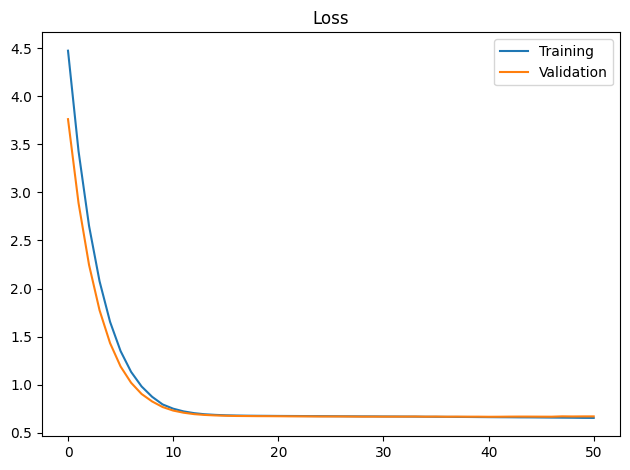

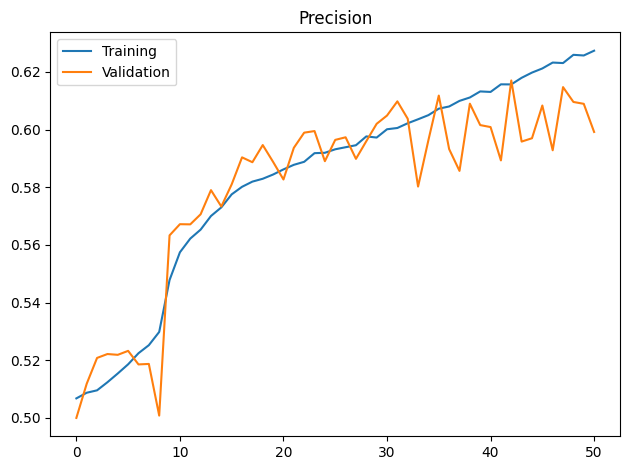

X.shape: (3444, 240, 10)
Y.shape: (3444, 1)
ticker.shape: (3683, 64)
3/3 [==============================] - 0s 23ms/step - loss: 0.6657 - accuracy: 0.5920 - precision: 0.2519 - recall: 0.5143
{'loss': 0.6656838655471802, 'accuracy': 0.5920441150665283, 'precision': 0.2519298195838928, 'recall': 0.5143266320228577}


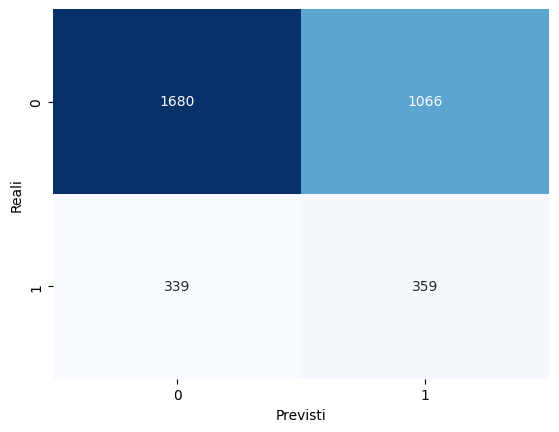

idx: (3444,)
pred: (3444, 1)
real: (3444, 1)


ValueError: 2 columns passed, passed data had 3444 columns

In [3]:
mod = Modello()
mod.crea(
    'mod_1_in', 
    class_weights={0: 1, 1: 1}, 
    bilanciamento=1, 
    timesteps=240, 
    batch_size=1500, 
    learning_rate=0.0001, 
    n_ticker_batch=400, 
    train_test_split=0.4,
    features=["EMA_5", "EMA_20", "EMA_50", "EMA_100", "Volume", "MACDh", "AROONOSC", "TRIX", "DM_OSC", "TSI", "KVO"]
)
df = mod.addestra(salva_carica_file_XY=True)
df
mod.salva()

modifica_target()

df = pd.read_hdf('tickers/BTG.h5', 'ticker')
fig = grafico(df)